In [1]:
%reset

import numpy as np
from sklearn import preprocessing
import math
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
from numpy import *


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D, Masking, CuDNNLSTM


from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

import seaborn as sns
from pylab import rcParams

from numpy.linalg import *
import math
from datetime import datetime
from datetime import timedelta


import tensorflow as tf
from tensorflow import keras
import os
import keras


os.environ["CUDA_VISIBLE_DEVICES"]='1'

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
# do stuff


%matplotlib inline


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Using TensorFlow backend.
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/jupyterhub/anaconda/lib/python3.6/site-packag

In [2]:
# Import the data and making a dataframe out of it
df_deli = pd.read_csv('../Emilio Caba/Data/Delivery.csv')
df_cons = pd.read_csv('../Emilio Caba/Data/Consumption.csv')
df_info = pd.read_csv('../Emilio Caba/Data/Information.csv')
df_weather = pd.read_csv('../Data/KNMI_Voorschoten_20170711_20190601.csv')

# Setting indexes
df_deli.set_index('ID-nummer',inplace=True)
df_deli.index = pd.to_datetime(df_deli.index)
df_deli.index.names = ['date']

df_cons.set_index('ID-nummer',inplace=True)
df_cons.index = pd.to_datetime(df_cons.index)
df_cons.index.names = ['date']

df_info.set_index('ID-nummer',inplace=True)
df_info.index.names = ['date']

df_weather.set_index('Date_and_time',inplace=True)
df_weather = df_weather.loc['2017-09-12':'2019-06-01 00:00:00']
df_weather.index = pd.to_datetime(df_weather.index)
df_weather.index.names = ['date']
df_weather = df_weather.apply(pd.to_numeric)

# Creating first row to datasets
top_row = [0 for col in df_deli.columns]
df_top_row = pd.DataFrame(top_row).transpose()

s_top_row = pd.Series([pd.to_datetime('2017-09-12 00:00:00')])
df_top_row.set_index(s_top_row, inplace=True)
df_top_row.columns = df_deli.columns

# Adding first row to the datasets
df_deli = pd.concat([df_top_row, df_deli])
df_cons = pd.concat([df_top_row, df_cons])

# Joining datasets
df_deli = df_deli.join(df_weather)
df_cons = df_cons.join(df_weather)

# Filling NaN temperature values with the previous ones
df_deli.fillna(method='ffill', inplace=True)
df_cons.fillna(method='ffill', inplace=True)

# Deleting first row (dummy row)
df_deli = df_deli.iloc[1:]
df_cons = df_cons.iloc[1:]

display(df_deli.head(2))
display(df_deli.shape)
display(df_cons.head(2))
display(df_cons.shape)



df_deli = df_deli.iloc[:-5]
df_cons = df_cons.iloc[:-5]


,H01,H02,H03,H04,H06,H07,H08,H09,H11,H13,...,H27,H28,H29,H31,H32,H33,T,SQ,Q,N
2017-09-12 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0


(54745, 32)

,H01,H02,H03,H04,H06,H07,H08,H09,H11,H13,...,H27,H28,H29,H31,H32,H33,T,SQ,Q,N
2017-09-12 00:15:00,0.031,0.048,0.027,0.017,0.074,0.012,0.023,0.055,0.075,0.131,...,0.096,0.025,0.024,0.299,0.027,0.022,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.037,0.023,0.034,0.015,0.069,0.024,0.020,0.036,0.071,0.088,...,0.152,0.018,0.028,0.325,0.021,0.042,14.8,0.0,0.0,7.0


(54745, 32)

In [3]:
from datetime import date, datetime

def get_season(year_day):
    spring = range(80, 172) # Corresponds to season 1
    summer = range(172, 264) # Corresponds to season 2
    fall = range(264, 355) # Corresponds to season 3
    # winter Corresponds to season 4

    if year_day in spring:
        season = 1
    elif year_day in summer:
        season = 2
    elif year_day in fall:
        season = 3
    else:
        season = 4
    return season

In [4]:


df_deli = df_deli[['H04','H09','H15','H02','H07','H20','H13','H27','H01','H03','H08','T','SQ','Q','N']] #3 houses per unique number of people
df_cons = df_cons[['H04','H09','H15','H02','H07','H20','H13','H27','H01','H03','H08','T','SQ','Q','N']]
df_info = df_info[['H04','H09','H15','H02','H07','H20','H13','H27','H01','H03','H08']]

display(df_deli)
display(df_cons)
display(df_info)

,H04,H09,H15,H02,H07,H20,H13,H27,H01,H03,H08,T,SQ,Q,N
2017-09-12 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.6,0.0,0.0,6.0
2017-09-12 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.6,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31 21:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,0.0,2.0
2019-05-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,0.0,8.0
2019-05-31 22:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,0.0,8.0
2019-05-31 22:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,0.0,8.0


,H04,H09,H15,H02,H07,H20,H13,H27,H01,H03,H08,T,SQ,Q,N
2017-09-12 00:15:00,0.017,0.055,0.033,0.048,0.012,0.029,0.131,0.096,0.031,0.027,0.023,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.015,0.036,0.033,0.023,0.024,0.017,0.088,0.152,0.037,0.034,0.020,14.8,0.0,0.0,7.0
2017-09-12 00:45:00,0.023,0.029,0.028,0.017,0.020,0.016,0.073,0.265,0.034,0.031,0.011,14.8,0.0,0.0,7.0
2017-09-12 01:00:00,0.015,0.035,0.028,0.023,0.019,0.023,0.078,0.062,0.296,0.021,0.012,14.6,0.0,0.0,6.0
2017-09-12 01:15:00,0.133,0.035,0.193,0.018,0.012,0.023,0.208,0.219,0.311,0.108,0.016,14.6,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31 21:45:00,0.030,0.041,0.030,0.050,0.022,0.036,0.045,0.144,0.020,0.036,0.035,13.1,0.0,0.0,2.0
2019-05-31 22:00:00,0.054,0.051,0.033,0.069,0.035,0.041,0.035,0.319,0.030,0.061,0.036,13.1,0.0,0.0,8.0
2019-05-31 22:15:00,0.037,0.179,0.027,0.056,0.070,0.041,0.039,0.344,0.043,0.080,0.057,13.1,0.0,0.0,8.0
2019-05-31 22:30:00,0.033,0.066,0.040,0.059,0.422,0.038,0.052,0.192,0.415,0.063,0.062,13.1,0.0,0.0,8.0


,H04,H09,H15,H02,H07,H20,H13,H27,H01,H03,H08
date,,,,,,,,,,,
concept,WP,E,WP,E,E,Zon,E,WP,E,WP,E
PV-aantal,11,14,9,14,13,10,15,9,17,9,9
personen,1,1,1,2,2,2,3,3,4,4,4


In [5]:
reverse = df_deli['H13'].iloc[::-1]
reverse = reverse.values


df_deli.insert(7, 'H13r', reverse)
df_cons.insert(7, 'H13r', reverse)

H13r = df_info['H13']
H13r = H13r.values
df_info.insert(7, 'H13r', H13r)


display(df_deli)
display(df_cons)
display(df_info)


,H04,H09,H15,H02,H07,H20,H13,H13r,H27,H01,H03,H08,T,SQ,Q,N
2017-09-12 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.8,0.0,0.0,7.0
2017-09-12 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.6,0.0,0.0,6.0
2017-09-12 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.6,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31 21:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,0.0,2.0
2019-05-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,0.0,8.0
2019-05-31 22:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,0.0,8.0
2019-05-31 22:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.1,0.0,0.0,8.0


,H04,H09,H15,H02,H07,H20,H13,H13r,H27,H01,H03,H08,T,SQ,Q,N
2017-09-12 00:15:00,0.017,0.055,0.033,0.048,0.012,0.029,0.131,0.0,0.096,0.031,0.027,0.023,14.8,0.0,0.0,7.0
2017-09-12 00:30:00,0.015,0.036,0.033,0.023,0.024,0.017,0.088,0.0,0.152,0.037,0.034,0.020,14.8,0.0,0.0,7.0
2017-09-12 00:45:00,0.023,0.029,0.028,0.017,0.020,0.016,0.073,0.0,0.265,0.034,0.031,0.011,14.8,0.0,0.0,7.0
2017-09-12 01:00:00,0.015,0.035,0.028,0.023,0.019,0.023,0.078,0.0,0.062,0.296,0.021,0.012,14.6,0.0,0.0,6.0
2017-09-12 01:15:00,0.133,0.035,0.193,0.018,0.012,0.023,0.208,0.0,0.219,0.311,0.108,0.016,14.6,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31 21:45:00,0.030,0.041,0.030,0.050,0.022,0.036,0.045,0.0,0.144,0.020,0.036,0.035,13.1,0.0,0.0,2.0
2019-05-31 22:00:00,0.054,0.051,0.033,0.069,0.035,0.041,0.035,0.0,0.319,0.030,0.061,0.036,13.1,0.0,0.0,8.0
2019-05-31 22:15:00,0.037,0.179,0.027,0.056,0.070,0.041,0.039,0.0,0.344,0.043,0.080,0.057,13.1,0.0,0.0,8.0
2019-05-31 22:30:00,0.033,0.066,0.040,0.059,0.422,0.038,0.052,0.0,0.192,0.415,0.063,0.062,13.1,0.0,0.0,8.0


,H04,H09,H15,H02,H07,H20,H13,H13r,H27,H01,H03,H08
date,,,,,,,,,,,,
concept,WP,E,WP,E,E,Zon,E,E,WP,E,WP,E
PV-aantal,11,14,9,14,13,10,15,15,9,17,9,9
personen,1,1,1,2,2,2,3,3,3,4,4,4


In [6]:
# Setting dummy variables

df_deli['season'] = [get_season(index.timetuple().tm_yday) for index in df_deli.index]
df_cons['season'] = [get_season(index.timetuple().tm_yday) for index in df_cons.index]

df_deli['month'] = df_deli.index.month
df_cons['month'] = df_cons.index.month

df_deli['week'] = df_deli.index.week
df_cons['week'] = df_cons.index.week

df_deli['day'] = df_deli.index.day
df_cons['day'] = df_cons.index.day

df_deli['hour'] = df_deli.index.hour
df_cons['hour'] = df_cons.index.hour




df_deli['hour'].unique()


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [7]:
# Setting different columns (delivery, consumption, houses_info, dummy_variables)
df = pd.DataFrame(columns=['delivery','consumption', 'T', 'SQ', 'Q', 'N','heating_sys','people','week','month','season','day','hour'])

num_houses_cols = 12
#num_houses_cols = 28
# Preparing the delivery and consumption arrays
ar_deli = np.array([])
ar_cons = np.array([])
for col in range(num_houses_cols):
    ar_deli = np.append(ar_deli, df_deli.values[:, col])
    ar_cons = np.append(ar_cons, df_cons.values[:, col])

# Preparing the houses information arrays
ar_heatSystem = np.array([])
ar_People = np.array([])
for col in df_info.columns:
    ar_heatSystem = np.append(ar_heatSystem, (df_info.loc[['concept'], [col]].values[0].tolist() * df_deli.shape[0]))
    ar_People = np.append(ar_People, (df_info.loc[['personen'], [col]].values[0].tolist() * df_deli.shape[0]))
    
# Inserting the data to the dataframe
df['delivery'] = pd.Series(ar_deli)
df['consumption'] = pd.Series(ar_cons)

df['T'] = df_deli['T'].values.tolist() * num_houses_cols
df['SQ'] = df_deli['SQ'].values.tolist() * num_houses_cols
df['Q'] = df_deli['Q'].values.tolist() * num_houses_cols
df['N'] = df_deli['N'].values.tolist() * num_houses_cols

df['month'] = df_deli['month'].values.tolist() * num_houses_cols
df['week'] = df_deli['week'].values.tolist() * num_houses_cols
df['season'] = df_deli['season'].values.tolist() * num_houses_cols
df['day'] = df_deli['day'].values.tolist() * num_houses_cols
df['hour'] = df_deli['hour'].values.tolist() * num_houses_cols

df['heating_sys'] = pd.Series(ar_heatSystem)
df['people'] = pd.Series(ar_People)

# Replacing heating system type by numbers
df.replace('E', 1, inplace=True)
df.replace('WP', 2, inplace=True)
df.replace('Zon', 3, inplace=True)

display(df.head())
display(df.shape)




,delivery,consumption,T,SQ,Q,N,heating_sys,people,week,month,season,day,hour
0,0.0,0.017,14.8,0.0,0.0,7.0,2,1,37,9,2,12,0
1,0.0,0.015,14.8,0.0,0.0,7.0,2,1,37,9,2,12,0
2,0.0,0.023,14.8,0.0,0.0,7.0,2,1,37,9,2,12,0
3,0.0,0.015,14.6,0.0,0.0,6.0,2,1,37,9,2,12,1
4,0.0,0.133,14.6,0.0,0.0,6.0,2,1,37,9,2,12,1


(656880, 13)

In [8]:
del_heat = df[['delivery','consumption','T','SQ','Q','week','month','season','day','hour']] #storing only the columns that i want to use to train, (all of them except the target variable)
del_heat.head()

,delivery,consumption,T,SQ,Q,week,month,season,day,hour
0,0.0,0.017,14.8,0.0,0.0,37,9,2,12,0
1,0.0,0.015,14.8,0.0,0.0,37,9,2,12,0
2,0.0,0.023,14.8,0.0,0.0,37,9,2,12,0
3,0.0,0.015,14.6,0.0,0.0,37,9,2,12,1
4,0.0,0.133,14.6,0.0,0.0,37,9,2,12,1


In [9]:
df['people'] = df['people'].astype(int)
df['people'].unique()

array([1, 2, 3, 4])

In [10]:
del_heat['day'] = del_heat['day'].astype(int)
del_heat['hour'] = del_heat['hour'].astype(int)



/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
x = del_heat.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled)

df_norm

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.006523,0.543529,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.000000
1,0.0,0.005756,0.543529,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.000000
2,0.0,0.008826,0.543529,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.000000
3,0.0,0.005756,0.538824,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.043478
4,0.0,0.051036,0.538824,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.043478
...,...,...,...,...,...,...,...,...,...,...
656875,0.0,0.013431,0.503529,0.0,0.0,0.411765,0.363636,0.000000,1.000000,0.913043
656876,0.0,0.013814,0.503529,0.0,0.0,0.411765,0.363636,0.000000,1.000000,0.956522
656877,0.0,0.021873,0.503529,0.0,0.0,0.411765,0.363636,0.000000,1.000000,0.956522
656878,0.0,0.023791,0.503529,0.0,0.0,0.411765,0.363636,0.000000,1.000000,0.956522


In [12]:
total = df_norm.values #array converting from the normalized dataframe 


In [13]:
#This code automatically calculates the best numbers for the reshape method
#
#divisions = [] 
#difference = np.inf
#day = 1 #Select the number of days you want to make your predictions on 
#
#for i in range(df_norm.shape[0]):
#    if (df_norm.shape[0] % (i+1) == 0):
#        divisions.append(i+1)
#        diff = abs((96*day)-(i+1))
#        if difference > diff:
#            difference = diff
#            rows = i+1
#        else:
#            pass
#        
#samples = int(df_norm.shape[0] / rows)


     
        
        
    

In [14]:

df_norm


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.006523,0.543529,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.000000
1,0.0,0.005756,0.543529,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.000000
2,0.0,0.008826,0.543529,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.000000
3,0.0,0.005756,0.538824,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.043478
4,0.0,0.051036,0.538824,0.0,0.0,0.705882,0.727273,0.333333,0.366667,0.043478
...,...,...,...,...,...,...,...,...,...,...
656875,0.0,0.013431,0.503529,0.0,0.0,0.411765,0.363636,0.000000,1.000000,0.913043
656876,0.0,0.013814,0.503529,0.0,0.0,0.411765,0.363636,0.000000,1.000000,0.956522
656877,0.0,0.021873,0.503529,0.0,0.0,0.411765,0.363636,0.000000,1.000000,0.956522
656878,0.0,0.023791,0.503529,0.0,0.0,0.411765,0.363636,0.000000,1.000000,0.956522


In [15]:
samples = 7140
rows = 92

df_arr = df_norm.values
a2 = df_arr.reshape(samples,rows,df_norm.shape[1]) #2380 samples #184rows per house #10features per house 

a2.shape

(7140, 92, 10)

In [16]:
labeled_out = np.zeros((df['people'].shape[0], 4))

for i in range(len(df['people'])):
    if df['people'][i] == 1:
        labeled_out[i] = [1,0,0,0]
    elif df['people'][i] == 2:
        labeled_out[i] = [0,1,0,0]
    elif df['people'][i] == 3:
        labeled_out[i] = [0,0,1,0]
    else:
        labeled_out[i] = [0,0,0,1]
        
labeled_out.shape

(656880, 4)

In [17]:
a2_out = labeled_out.reshape(samples,rows,labeled_out.shape[1]) #2380 samples #184 per house #3features per house 

a2_out.shape

(7140, 92, 4)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(a2,a2_out, test_size=0.3) #splitin the 30% of the data to test



In [19]:
model = Sequential()

In [20]:
X_train.shape[2]

10

In [21]:
#
n_features = X_train.shape[2]   #X_train.shape[1]
timesteps = X_train.shape[1]   #1


# Recurrent layer     
model.add(LSTM(60, input_shape=(timesteps, n_features), return_sequences=True))
#model.add(LSTM(30, input_shape=(timesteps, n_features), dropout=0.2, recurrent_dropout=0.1))
#model.add(LSTM(10,dropout=0.2))
model.add(Dropout(0.20))

# Fully connected layer
#model.add(Dense(20, activation='relu'))#relu/linear
#model.add(Dropout(0.25))

# Output layer
model.add(Dense(4, activation='softmax'))#softmax/softmax para cada tipo de neurona

#with lstm/dropout/dense 4/ at 40 epoch got 50%, at 60 epoch got 55%


In [22]:
lr= 0.01 

model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(lr), metrics = ['accuracy'])#loss = mean_squared_error
#loss= mean_squared_error
#binary_crossentropy got 80%
#mean_squared_logarithmic_error 63% acc /  0.0581 val_acc

In [23]:
#X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

#X_test = np.reshape(X_test, (X_test.shape[0], 1 ,X_test.shape[1]))



In [24]:

Y_train = Y_train.astype(int)

In [25]:

history = model.fit(X_train, Y_train,validation_split = 0.2,  epochs = 100) #storing in the history variable to plot it after (loss and accuracy)
#at 68 epoch with lr = 0.01 start overfittin

Train on 3998 samples, validate on 1000 samples
Epoch 1/100
3998/3998 [==============================] - 11s 3ms/step - loss: 0.5644 - acc: 0.7500 - val_loss: 0.5598 - val_acc: 0.7501
Epoch 2/100
3998/3998 [==============================] - 11s 3ms/step - loss: 0.5635 - acc: 0.7498 - val_loss: 0.5615 - val_acc: 0.7504
Epoch 3/100
3998/3998 [==============================] - 11s 3ms/step - loss: 0.5602 - acc: 0.7497 - val_loss: 0.5545 - val_acc: 0.7504
Epoch 4/100
3998/3998 [==============================] - 11s 3ms/step - loss: 0.5596 - acc: 0.7501 - val_loss: 0.5582 - val_acc: 0.7516
Epoch 5/100
3998/3998 [==============================] - 11s 3ms/step - loss: 0.5563 - acc: 0.7502 - val_loss: 0.5494 - val_acc: 0.7537
Epoch 6/100
3998/3998 [==============================] - 12s 3ms/step - loss: 0.5427 - acc: 0.7556 - val_loss: 0.5393 - val_acc: 0.7588
Epoch 7/100
3998/3998 [==============================] - 11s 3ms/step - loss: 0.5456 - acc: 0.7528 - val_loss: 0.5374 - val_acc: 0.7559


In [26]:
model.evaluate(X_test,Y_test)



2142/2142 [==============================] - 1s 646us/step


[0.3631052120782637, 0.8474150529873916]

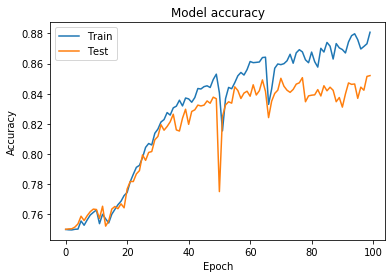

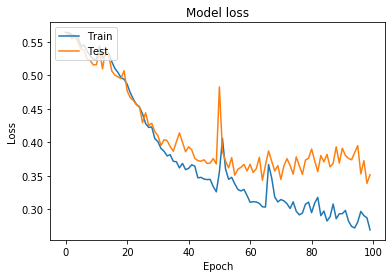

In [27]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [28]:
X_predict = model.predict(X_test)

In [29]:
X_test[0][1]

array([0.        , 0.08979279, 0.28470588, 0.        , 0.00597015,
       0.92156863, 0.90909091, 0.66666667, 0.86666667, 0.69565217])

In [30]:
X_predict_round = X_predict

for i in range(len(X_predict_round)):
    if X_predict_round[i][rows-1][0] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [1,0,0,0]
    elif X_predict_round[i][rows-1][1] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [0,1,0,0]
    elif X_predict_round[i][rows-1][2] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [0,0,1,0]
    elif X_predict_round[i][rows-1][3] == X_predict[i][rows-1].max():
        X_predict_round[i][rows-1] = [0,0,0,1]
        
#X_predict_round = X_predict_round /100

In [31]:

accuracy = np.empty(len(Y_test))

for i in range(len(X_predict_round)):
    if np.array_equal(X_predict_round[i][rows-1], Y_test[i][rows-1]):
        accuracy[i] = True
    else:
        accuracy[i] = False
 
print('the final accuracy is: ' + str(np.mean(accuracy)*100) + '%')

the final accuracy is: 82.53968253968253%


In [32]:
Y_test.shape[0]

2142

In [33]:
Y_test = Y_test.astype(int)
X_predict_round[0][rows-1]

array([0., 0., 0., 1.], dtype=float32)

In [34]:

Y_real = np.zeros([Y_test.shape[0],Y_test.shape[1]])

for i in range(Y_test.shape[0]):
    if np.array_equal(Y_test[i][rows-1], [1,0,0,0]):
        Y_real[i] = 1

    elif np.array_equal(Y_test[i][rows-1], [0,1,0,0]):
        Y_real[i] = 2
        
    elif np.array_equal(Y_test[i][rows-1], [0,0,1,0]):
        Y_real[i] = 3

    else:
        Y_real[i] = 4
      


In [35]:
X_predicted = np.zeros([X_predict_round.shape[0],X_predict_round.shape[1]])
    
    
for i in range(X_predict_round.shape[0]):
    if np.array_equal(X_predict_round[i][rows-1], [1,0,0,0]):
        X_predicted[i] = 1

    elif np.array_equal(X_predict_round[i][rows-1], [0,1,0,0]):
        X_predicted[i] = 2
        
    elif np.array_equal(X_predict_round[i][rows-1], [0,0,1,0]):
        X_predicted[i] = 3

    else:
        X_predicted[i] = 4


In [36]:
X_predicted_flatten = X_predicted.ravel()
print(X_predicted_flatten)

Y_real_flatten = Y_real.ravel()
print(Y_real_flatten)


[4. 4. 4. ... 2. 2. 2.]
[4. 4. 4. ... 2. 2. 2.]


[[38364  3312  3404  2852]
 [ 1564 43056   276  4048]
 [ 4876   368 37812  7912]
 [ 2116  1748  1932 43424]]


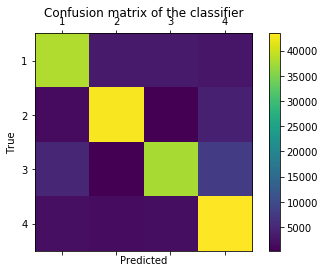


              precision    recall  f1-score   support

         1.0       0.82      0.80      0.81     47932
         2.0       0.89      0.88      0.88     48944
         3.0       0.87      0.74      0.80     50968
         4.0       0.75      0.88      0.81     49220

   micro avg       0.83      0.83      0.83    197064
   macro avg       0.83      0.83      0.83    197064
weighted avg       0.83      0.83      0.83    197064



In [37]:


from sklearn.metrics import confusion_matrix

y_test = Y_real_flatten #* 10 #multiply to 10 to avoid the decimals (the confusion matrix get integers)

pred = X_predicted_flatten#*10 #multiply to 10 to avoid the decimals (the confusion matrix get integers)

labels = [1, 2, 3, 4] #the 3 labels we want to find (remember thereare the normalized data * 10)
cm = confusion_matrix(y_test, pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + ['1', '2', '3','4'])
ax.set_yticklabels([''] + ['1', '2', '3','4'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

print()

print(classification_report(y_test, pred))

#model.save_weights("model_People_80.h5")
#print("Saved model to disk")

In [52]:
!nvidia-smi


Wed Nov 27 14:16:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M10           Off  | 00000000:DA:00.0 Off |                  N/A |
| N/A   42C    P0    16W /  53W |   1805MiB /  8127MiB |     13%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M10           Off  | 00000000:DB:00.0 Off |                  N/A |
| N/A   39C    P0    16W /  53W |   7797MiB /  8127MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 92, 60)            17040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 92, 60)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 92, 4)             244       
Total params: 17,284
Trainable params: 17,284
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.save_weights('model_People_83.h5')